In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from time import time
from CBFV import composition
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler, normalize, OrdinalEncoder
from sklearn.model_selection import learning_curve, RandomizedSearchCV, cross_validate, GroupKFold
import shap
import random
import difflib

/Users/andrew/Desktop/School/Research/ChemML/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RNG_SEED = 8
np.random.seed(RNG_SEED)
curr_dir = os.getcwd()
DATA_PATH = os.path.join(os.path.dirname(curr_dir), 'Data')
MODELS_PATH = os.path.join(os.path.dirname(curr_dir), 'Models')
WEIGHTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Weights')
ASSETS_PATH = os.path.join(os.path.dirname(curr_dir), 'Assets')
RESULTS_PATH = os.path.join(os.path.dirname(curr_dir), 'Results')

In [3]:
df_train = pd.read_csv(DATA_PATH + "/intermetallics_train7.csv")
df_val = pd.read_csv(DATA_PATH + "/intermetallics_val7.csv")
df_test = pd.read_csv(DATA_PATH + "/intermetallics_test7.csv")

In [4]:
df_train.head()

,material_id,formula,jml_bp_mult_atom_rad,jml_hfus_add_bp,jml_elec_aff_mult_voro_coord,jml_mol_vol_subs_atom_mass,jml_is_halogen,jml_atom_mass_subs_first_ion_en,jml_row,jml_mol_vol_mult_atom_mass,...,SumCoNi,SumMnFeCo,SumMnFeNi,SumMnFeCr,SumCrMnCo,SumCrFeCo,SumCrMnNi,SumCrFeNi,SumCrCoNi,SumFeNiCo
0,mp-1217137,Ti2CrTe4,3623.666667,2588.508433,5.541333,-63.044367,0.0,68.286290,4.333333,1165.310894,...,0.0,0.0,0.0,0.142857,0.142857,0.142857,0.142857,0.142857,0.142857,0.0
1,mp-1203616,Y6Al43Cr4,4702.600000,3115.143667,4.928667,-43.591163,0.0,49.637970,4.000000,804.398496,...,0.0,0.0,0.0,0.075472,0.075472,0.075472,0.075472,0.075472,0.075472,0.0
2,mp-1022649,YMg6Cr,4220.766667,2638.802900,3.228667,-41.365650,0.0,48.192302,4.000000,827.883367,...,0.0,0.0,0.0,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.0
3,mp-2132,CrN,2085.942000,1510.786775,3.320000,-22.616400,0.0,22.351095,3.000000,282.791261,...,0.0,0.0,0.0,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.0
4,mp-1190957,GdCrB4,4677.666667,3555.936233,2.588333,-62.845700,0.0,66.280923,4.666667,1184.222364,...,0.0,0.0,0.0,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.0


In [5]:
df_train.columns

Index(['material_id', 'formula', 'jml_bp_mult_atom_rad', 'jml_hfus_add_bp',
       'jml_elec_aff_mult_voro_coord', 'jml_mol_vol_subs_atom_mass',
       'jml_is_halogen', 'jml_atom_mass_subs_first_ion_en', 'jml_row',
       'jml_mol_vol_mult_atom_mass',
       ...
       'SumCoNi', 'SumMnFeCo', 'SumMnFeNi', 'SumMnFeCr', 'SumCrMnCo',
       'SumCrFeCo', 'SumCrMnNi', 'SumCrFeNi', 'SumCrCoNi', 'SumFeNiCo'],
      dtype='object', length=1599)

In [24]:
unique_count = df_train['material_id'].nunique()
dups = len(df_train) - unique_count
percent = unique_count/len(df_train) * 100
print(dups, percent, unique_count)

675 88.50476839237056 5197


In [ ]:
df_train_clean = df_train.drop_duplicates()
len(df_train_clean)

5197

In [27]:
unique_count = df_val['material_id'].nunique()
dups = len(df_val) - unique_count
percent = unique_count/len(df_val) * 100
print(dups, percent, unique_count)

218 87.34030197444832 1504


In [26]:
df_val_clean = df_val.drop_duplicates()
len(df_val_clean)

1504

In [29]:
unique_count = df_test['material_id'].nunique()
dups = len(df_test) - unique_count
percent = unique_count/len(df_test) * 100
print(dups, percent, unique_count)

97 88.50710900473933 747


In [28]:
df_test_clean = df_test.drop_duplicates()
len(df_test_clean)

747

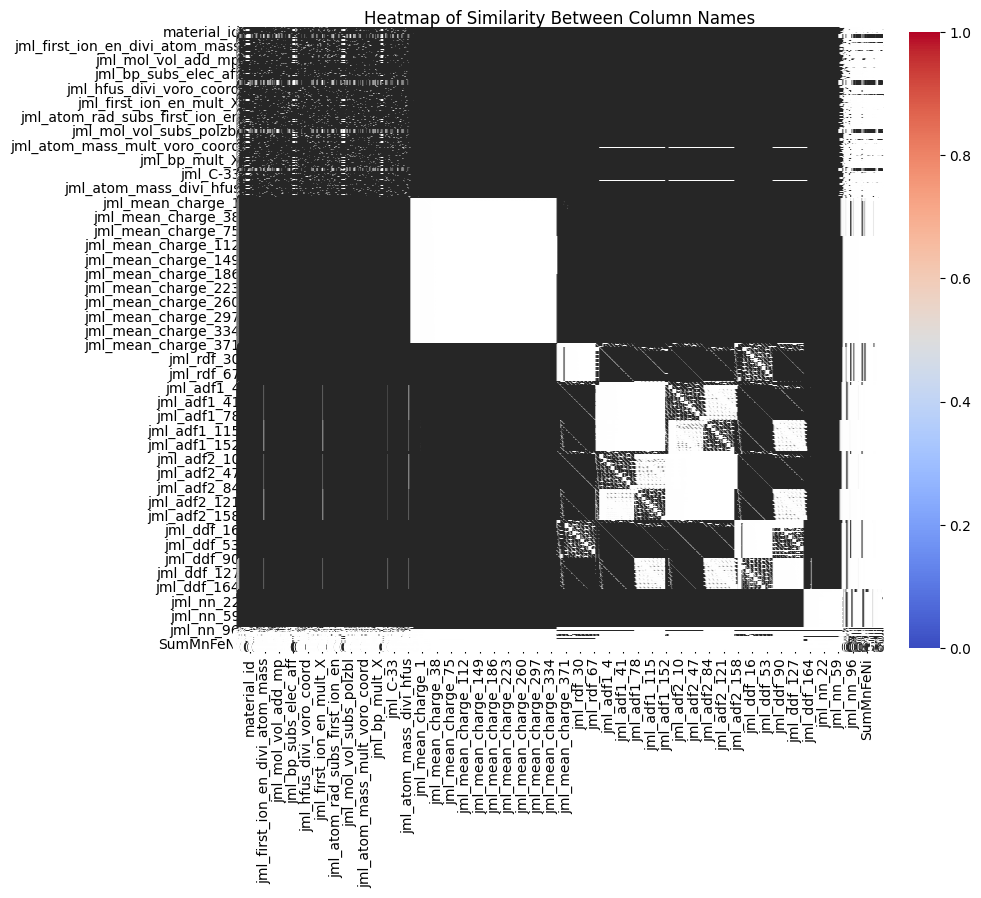

In [ ]:
columns = df_train.columns

similarity_matrix = pd.DataFrame(
    [[difflib.SequenceMatcher(None, col1, col2).ratio()
      for col2 in columns] for col1 in columns],
    index=columns,
    columns=columns
)

similarity_matrix_normalized = (similarity_matrix - similarity_matrix.min(
).min()) / (similarity_matrix.max().max() - similarity_matrix.min().min())

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_normalized, annot=True, cmap='coolwarm',
            linewidths=0.5, vmin=0, vmax=1)
plt.title('Heatmap of Similarity Between Column Names')
plt.show()

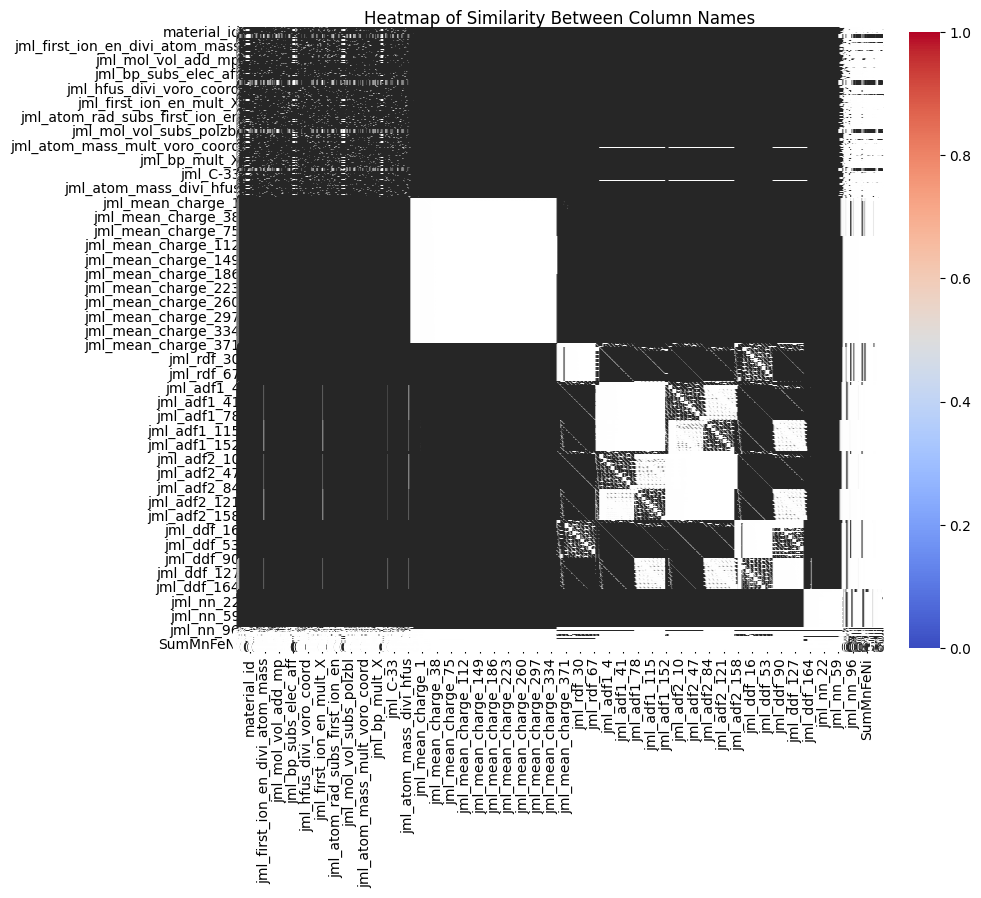

In [13]:
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_normalized, annot=True, cmap='coolwarm',
            linewidths=0.5, vmin=0, vmax=1)
plt.title('Heatmap of Similarity Between Column Names')
plt.show()

In [ ]:
# Confusion Matrix
# Mutltcollinearity Map
# Feature Importance
# Density Actual vs Predicted
# Correlation Matrix + Heatmap
# Weights across folds scatterplot